<a href="https://colab.research.google.com/github/SeraphDev6/Pnuemonia_Image_Classification/blob/main/Pneumonia_X_Ray_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pneumonia Classification by Wesley Giles

## Data Citation
Data: https://data.mendeley.com/datasets/rscbjbr9sj/2

License: CC BY 4.0

Citation: http://www.cell.com/cell/fulltext/S0092-8674(18)30154-5

## Load data and necessary modules

In [4]:
! chmod 600 /root/.kaggle/kaggle.json
! kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
! unzip chest-xray-pneumonia.zip
! pip install imagehash

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0448-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0449-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0450-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0451-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0452-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0453-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0453-0001.jpeg  
  inflating: chest_xray/tra

In [5]:
try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from skimage import io
import seaborn as sns
from PIL import Image
from imagehash import average_hash

## Let's start with checking for duplicate images
### Code refactored from example by [Somil Shah](https://medium.com/@somilshah112/how-to-find-duplicate-or-similar-images-quickly-with-python-2d636af9452f)

In [6]:
def find_duplicates(root):
  known_hashes = {}
  duplicates = []
  for cls in ["NORMAL","PNEUMONIA"]:
    for path in [os.path.join(root,cls,d) for d in os.listdir(os.path.join(root, cls))]:
      with Image.open(path) as img:
        hash = average_hash(img)
        if hash in known_hashes:
          duplicates.append(path)
        else:
          known_hashes[hash] = path
  return duplicates

dupes = find_duplicates("/content/chest_xray/train/")
len(dupes)

254

## Wow 254 duplicates. Let's drop these and check the other directories for duplicates

In [7]:
def drop_files(paths):
  for path in paths:
    os.remove(path)
drop_files(dupes)
print(f"Training duplicates: {len(find_duplicates('/content/chest_xray/train/'))}")
print(f"Testing duplicates: {len(find_duplicates('/content/chest_xray/test/'))}")
print(f"Validation duplicates: {len(find_duplicates('/content/chest_xray/val/'))}")

Training duplicates: 0
Testing duplicates: 16
Validation duplicates: 0


## Now that we know the drop files works, lets drop the duplicated testing images

In [8]:
drop_files(find_duplicates('/content/chest_xray/test/'))

## Lets take a look at the balance of the train data

In [9]:
def get_file_counts(root):
  di = {}
  for dir in [d for d in os.listdir(root) if os.path.isdir(os.path.join(root,d))]:
    di[dir] = len([f for f in os.listdir(os.path.join(root,dir)) if os.path.isfile(os.path.join(root,dir,f))])
  return di
get_file_counts("/content/chest_xray/train/")

{'NORMAL': 1260, 'PNEUMONIA': 3702}

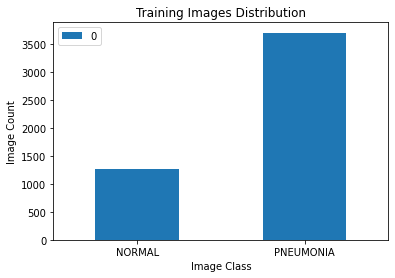

In [10]:
def get_bal_chart(root,title = None):
  bal = pd.DataFrame.from_dict(get_file_counts(root), orient = "index")
  bal.plot.bar()
  plt.gca().set_xlabel("Image Class")
  plt.gca().set_ylabel("Image Count")
  plt.gca().set_xticklabels(plt.gca().get_xticklabels(), rotation = 0)
  if title:
    plt.gca().set_title(title)
  plt.show()
get_bal_chart("/content/chest_xray/train/","Training Images Distribution")

## Seems we have significantly more Pnuemonia images than normal in this dataset, lets check test and val to ensure the same balance is in those sets

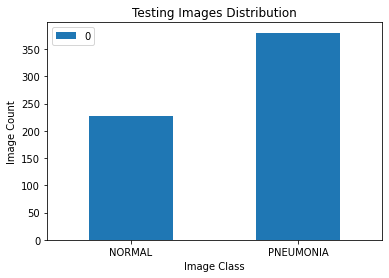

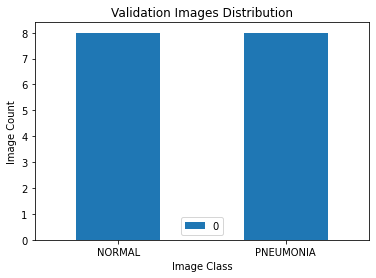

In [11]:
get_bal_chart("/content/chest_xray/test/", "Testing Images Distribution")
get_bal_chart("/content/chest_xray/val/", "Validation Images Distribution")

## While not perfectly balanced, both the train and test are skewed towards the positive indicator, which will allow us to more accurately predict Pnuemonia.

## Let's try to get some data on the attributes of the images

In [12]:
def average_brightness(path):
  return io.imread(path).mean(axis=0).mean(axis=0).mean()

In [13]:
def get_average_brightness_df(root):
  data = []
  for dir in ["NORMAL","PNEUMONIA"]:
    data += [(average_brightness(os.path.join(root,dir,im)), dir, os.path.join(root,dir,im)) for im in os.listdir(os.path.join(root,dir))]
  return pd.DataFrame(data, columns = ["Average Brightness","Classification","Path"]) 
df = get_average_brightness_df("/content/chest_xray/train/")

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 66.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 81.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'Distribution of Brightness by Classification')

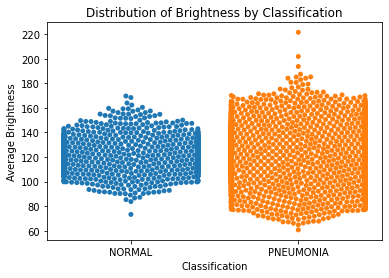

In [14]:
sns.swarmplot(data = df, 
              x = "Classification",
              y = "Average Brightness")
plt.gca().set_title("Distribution of Brightness by Classification")

## It looks like there are several images with a very high brightness. Let's take a look at those

In [15]:
high_sat = df[df['Average Brightness']>190]
high_sat

,Average Brightness,Classification,Path
3246,193.691671,PNEUMONIA,/content/chest_xray/train/PNEUMONIA/person1510...
3282,201.838906,PNEUMONIA,/content/chest_xray/train/PNEUMONIA/person1405...
3324,221.536623,PNEUMONIA,/content/chest_xray/train/PNEUMONIA/person1413...


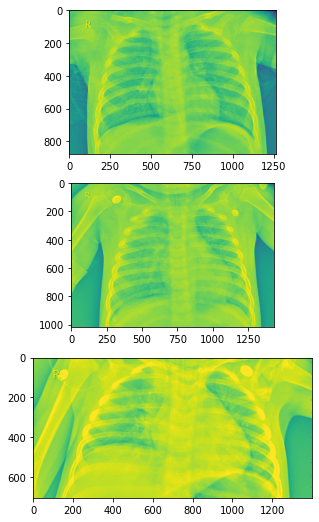

In [16]:
fig, axes = plt.subplots(len(high_sat),figsize = (5,9))
for idx, image in enumerate(high_sat["Path"]):
  axes[idx].imshow(Image.open(image))

## These images are still likely to work with the dataset. We just have to ensure the images are normalized in our model

## Now let's go ahead and set up the streams to get the images from the directories

In [17]:
IMG_HEIGHT, IMG_WIDTH = 256,256
image_gen = keras.preprocessing.image.ImageDataGenerator(rescale = 1.0/255)

train_gen = image_gen.flow_from_directory("/content/chest_xray/train/",
                                          target_size=(IMG_HEIGHT,IMG_WIDTH),
                                          class_mode = "sparse",
                                          classes=["NORMAL","PNEUMONIA"])
test_gen = image_gen.flow_from_directory("/content/chest_xray/test/",
                                          target_size=(IMG_HEIGHT,IMG_WIDTH),
                                          class_mode = "sparse",
                                          classes=["NORMAL","PNEUMONIA"])
val_gen = image_gen.flow_from_directory("/content/chest_xray/val/",
                                          target_size=(IMG_HEIGHT,IMG_WIDTH),
                                          class_mode = "sparse",
                                          classes=["NORMAL","PNEUMONIA"])

Found 4962 images belonging to 2 classes.
Found 608 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


## It seems like the Pneumonia data set has a wider range of Average Brightness than the normal, likely due to the larger data set. Let's visualize some of the images

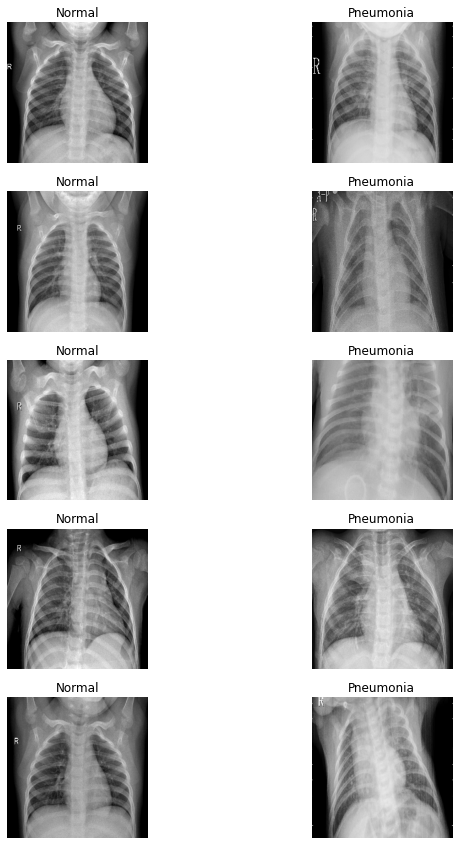

In [18]:
def show_image_samples(image_list, class_list):
  fig, axes = plt.subplots(5,2, figsize= (10,15))
  num_normal, num_pneumonia = 0, 0
  for idx, image in enumerate(image_list):
    if class_list[idx] == 0 and num_normal < 5:
      ax = axes[num_normal,0]
      ax.imshow(image)
      ax.axis("off")
      ax.set_title("Normal")
      num_normal += 1 
    elif class_list[idx] == 1 and num_pneumonia < 5 :
      ax = axes[num_pneumonia,1]
      ax.imshow(image)
      ax.axis("off")
      ax.set_title("Pneumonia")
      num_pneumonia += 1
  plt.show()

show_image_samples(*next(train_gen))

## Now let's design the model using keras

In [19]:
model = keras.Sequential([
    keras.layers.Conv2D(16, 3, activation = "relu", input_shape = (IMG_HEIGHT,IMG_WIDTH, 3)),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(32, 3, activation = "relu"),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(64, 3, activation = "relu"),
    keras.layers.Flatten(),
    keras.layers.Dense(32, activation="relu"),
    keras.layers.Dense(2)
])

model.compile(
     optimizer = "adam",
     loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
     metrics = ["accuracy"]
 )


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 flatten (Flatten)           (None, 230400)            0

## Now let's fit the model with an early stopping callback to prevent overfitting

In [20]:
early_stopping = tf.keras.callbacks.EarlyStopping(min_delta = 0.001, patience = 10, restore_best_weights=True)

history = model.fit(x = train_gen,
                    epochs = 100,
                    validation_data = test_gen,
                    callbacks = [early_stopping]
                    )

Epoch 1/100
156/156 [==============================] - 331s 2s/step - loss: 0.2278 - accuracy: 0.9097 - val_loss: 1.2786 - val_accuracy: 0.7105
Epoch 2/100
156/156 [==============================] - 331s 2s/step - loss: 0.0994 - accuracy: 0.9641 - val_loss: 0.5820 - val_accuracy: 0.7599
Epoch 3/100
156/156 [==============================] - 329s 2s/step - loss: 0.0594 - accuracy: 0.9794 - val_loss: 0.7837 - val_accuracy: 0.7862
Epoch 4/100
156/156 [==============================] - 326s 2s/step - loss: 0.0413 - accuracy: 0.9845 - val_loss: 1.8454 - val_accuracy: 0.7072
Epoch 5/100
156/156 [==============================] - 325s 2s/step - loss: 0.0494 - accuracy: 0.9831 - val_loss: 0.6271 - val_accuracy: 0.8372
Epoch 6/100
156/156 [==============================] - 325s 2s/step - loss: 0.0436 - accuracy: 0.9827 - val_loss: 1.7558 - val_accuracy: 0.7138
Epoch 7/100
156/156 [==============================] - 324s 2s/step - loss: 0.0209 - accuracy: 0.9919 - val_loss: 1.7546 - val_accuracy: